In [ ]:
#doing the PCA for Control V.S. Alzeimers

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import mne
import entropy as ent
import neurokit2 as nk
from scipy.signal import welch
from nolds import lyap_r
import antropy as ant
import joblib

In [74]:
#loading in the dataframs 

In [75]:
alz_df = pd.read_pickle("Alzeimers.pkl")
control_df = pd.read_pickle("Control.pkl")

In [76]:
print(type(alz_df.loc[('sub-001', 'Fp1', 'Delta'), "Window Avg"][0]))
print(alz_df.loc[('sub-001', 'Fp1', 'Delta'), "Window Avg"][0])
print(type(alz_df.loc[('sub-001', 'Fp1', 'Delta'), "Window Avg"]))
print(alz_df.loc[('sub-001', 'Fp1', 'Delta'), "Window Avg"])

<class 'numpy.float64'>
5.607240819161222e-07
<class 'list'>
[np.float64(5.607240819161222e-07), np.float64(2.136206557103639e-07), np.float64(1.4815955569749812e-07), np.float64(1.1329436172684679e-07), np.float64(7.296527914043617e-08), np.float64(6.059866918225963e-08), np.float64(1.0361302410499309e-07), np.float64(2.3086230197239276e-07), np.float64(1.0552505598702842e-07), np.float64(8.896397838702983e-08), np.float64(6.57345729309926e-08), np.float64(6.71105777754649e-08), np.float64(1.6631586295502842e-07), np.float64(1.5266041712409792e-07), np.float64(5.313955773328878e-07), np.float64(6.700614808615797e-07), np.float64(3.464982345643528e-07), np.float64(1.0609118614977464e-06), np.float64(6.268996717597441e-07), np.float64(9.355173677896289e-08), np.float64(1.194314537437679e-07), np.float64(2.9432058402460086e-07), np.float64(3.0417203518634765e-07), np.float64(1.0967247840000785e-07), np.float64(9.184340855409266e-08), np.float64(7.298744113820288e-08), np.float64(6.505383

In [77]:
# **I don't think this is needed **
# participantsInfo = pd.read_table('./ds004504/participants.tsv')
# #Getting all the groups
# A_sub = participantsInfo[participantsInfo["Group"] == "A"]["participant_id"].tolist()
# C_sub = participantsInfo[participantsInfo["Group"] == "C"]["participant_id"].tolist()
# D_sub = participantsInfo[participantsInfo["Group"] == "F"]["participant_id"].tolist()

In [78]:
# Print Alzheimer's preview
print(f"Alzheimer's preview for sub-001")
print(alz_df.loc['sub-001']) 
print(f"Control's preview for sub-037")
print(control_df.loc['sub-037'])
# # Print Control preview
# print(f"Control preview {C_sub[0]}")
# print(groups["Control"].loc[C_sub[0]])  

# # Print Dementia preview
# print(f"Dementia preview {D_sub[0]}")
# print(groups["Dementia"].loc[D_sub[0]])  

Alzheimer's preview for sub-001
                                                      Window Avg
Channel Band                                                    
Fp1     Delta  [5.607240819161222e-07, 2.136206557103639e-07,...
        Theta  [1.4290601340850907e-08, 2.322876797863479e-08...
        Alpha  [2.877208402057422e-09, 1.7605723328087318e-09...
        Beta   [5.046764330104262e-10, 5.503217253688624e-10,...
Fp2     Delta  [5.465781151565962e-07, 2.1364434568508706e-07...
...                                                          ...
Cz      Beta   [3.205899994916665e-10, 3.5335248547358265e-10...
Pz      Delta  [1.5562185234722875e-07, 2.6102165698186886e-0...
        Theta  [4.1626502960822e-09, 7.189374463466653e-09, 6...
        Alpha  [1.2805820794756784e-09, 1.1287029520125796e-0...
        Beta   [3.338654724073159e-10, 3.9571401318770685e-10...

[76 rows x 1 columns]
Control's preview for sub-037
                                                      Window Avg
Chann

In [79]:
# Creating training and testing data. Going to set aside 2 subjects for each group 


In [80]:
# Get unique subject IDs
alz_subjects = alz_df.index.get_level_values("Subject").unique()
control_subjects = control_df.index.get_level_values("Subject").unique()

# Select the last 3 subjects for testing
test_alz_subjects = alz_subjects[-3:]  # Last 3 subjects
test_control_subjects = control_subjects[-3:]  # Last 3 subjects

# Select training subjects (all except the last 3)
train_alz_subjects = alz_subjects[:-3]
train_control_subjects = control_subjects[:-3]

# Split DataFrames
alz_train_df = alz_df.loc[train_alz_subjects]
alz_test_df = alz_df.loc[test_alz_subjects]

control_train_df = control_df.loc[train_control_subjects]
control_test_df = control_df.loc[test_control_subjects]

# Print confirmation
print("Train Alzheimer's subjects:", train_alz_subjects.tolist())
print("Test Alzheimer's subjects:", test_alz_subjects.tolist())
print("*"*64)
print("Train Control subjects:", train_control_subjects.tolist())
print("Test Control subjects:", test_control_subjects.tolist())


Train Alzheimer's subjects: ['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-029', 'sub-030', 'sub-031', 'sub-032', 'sub-033']
Test Alzheimer's subjects: ['sub-034', 'sub-035', 'sub-036']
****************************************************************
Train Control subjects: ['sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-047', 'sub-048', 'sub-049', 'sub-050', 'sub-051', 'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-060', 'sub-061', 'sub-062']
Test Control subjects: ['sub-063', 'sub-064', 'sub-065']


In [81]:
# Remove subject from index, but keep channel band window **need to work on this now 

In [82]:
#checking the data start state
print(alz_train_df.loc['sub-001']) 
print(alz_train_df) 

print(type(alz_train_df.loc[('sub-001', 'Fp1', 'Delta'), "Window Avg"][0]))
print(alz_train_df.loc[('sub-001', 'Fp1', 'Delta'), "Window Avg"][0])

                                                      Window Avg
Channel Band                                                    
Fp1     Delta  [5.607240819161222e-07, 2.136206557103639e-07,...
        Theta  [1.4290601340850907e-08, 2.322876797863479e-08...
        Alpha  [2.877208402057422e-09, 1.7605723328087318e-09...
        Beta   [5.046764330104262e-10, 5.503217253688624e-10,...
Fp2     Delta  [5.465781151565962e-07, 2.1364434568508706e-07...
...                                                          ...
Cz      Beta   [3.205899994916665e-10, 3.5335248547358265e-10...
Pz      Delta  [1.5562185234722875e-07, 2.6102165698186886e-0...
        Theta  [4.1626502960822e-09, 7.189374463466653e-09, 6...
        Alpha  [1.2805820794756784e-09, 1.1287029520125796e-0...
        Beta   [3.338654724073159e-10, 3.9571401318770685e-10...

[76 rows x 1 columns]
                                                              Window Avg
Subject Channel Band                                       

# NEED to do the preprocessing with train and test instead of the combined value

In [89]:
#combining alz data
alz_train_df_combined = alz_train_df.groupby(["Channel", "Band"])["Window Avg"].sum().to_frame()
alz_test_df_combined = alz_test_df.groupby(["Channel", "Band"])["Window Avg"].sum().to_frame()

control_train_df_combined = control_train_df.groupby(["Channel", "Band"])["Window Avg"].sum().to_frame()
control_test_df_combined = control_test_df.groupby(["Channel", "Band"])["Window Avg"].sum().to_frame()

In [90]:
print(alz_train_df_combined.head())

                                                      Window Avg
Channel Band                                                    
C3      Alpha  [1.1952646428442352e-09, 1.243587730757724e-09...
        Beta   [3.440334682399176e-10, 3.3680858853976883e-10...
        Delta  [1.343193533659429e-07, 2.6631502953716043e-07...
        Theta  [4.612288195341671e-09, 5.628089980277074e-09,...
C4      Alpha  [1.15823465152569e-09, 9.120024993533683e-10, ...


In [117]:
#checking the state
# print(alz_train_df_combined) 
# print(control_train_df_combined) 

print(type(alz_train_df_combined.loc[('Fp1', 'Delta'), "Window Avg"]))
print(type(np.array(alz_train_df_combined.loc[('Fp1', 'Delta'), "Window Avg"])))
print(type(alz_train_df_combined.loc[('Fp1', 'Delta'), "Window Avg"][0]))
# print((alz_train_df_combined.loc[('Fp1', 'Delta'), "Window Avg"]))
# print(alz_combined.loc[('sub-001', 'Fp1', 'Delta'), "Window Avg"][0])

<class 'list'>
<class 'numpy.ndarray'>
<class 'numpy.float64'>


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Function to apply StandardScaler per band
def normalize_band(df):
    df = df.copy()  # Avoid modifying original dataframe
    scaler = StandardScaler()
    
    # Convert "Window Avg" lists to NumPy arrays
    df["Window Avg"] = df["Window Avg"].apply(lambda x: np.array(x) if isinstance(x, list) else x)
    
    # Stack arrays into a 2D matrix
    X = np.vstack(df["Window Avg"].values)  
    
    # Scale values
    X_scaled = scaler.fit_transform(X)
    
    # Store back in DataFrame
    df["Window Avg"] = list(X_scaled)
    
    return df

# Apply function to each Band separately
alz_scaled = alz_combined.groupby("Band", group_keys=False).apply(normalize_band)
control_scaled = control_combined.groupby("Band", group_keys=False).apply(normalize_band)

# Print first few rows
print(alz_scaled.head())
print(control_scaled.head())

In [121]:
import numpy as np

# Function to normalize train & test data per channel and band
def normalize_band(train_df, test_df):
    # Make copies to avoid modifying original data
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Iterate through each unique (Channel, Band) pair in training set
    for (channel, band) in train_df.index.unique():
        try:
            print(f"Current ({channel}, {band}) ")
            
            # Get the "Window Avg" list for the current channel-band pair
            train_values = np.array(train_df.loc[(channel, band), "Window Avg"])
            test_values = np.array(test_df.loc[(channel, band), "Window Avg"])

            # Compute mean and standard deviation from training set
            mean_train = np.mean(train_values)
            std_train = np.std(train_values)

            # Check data distribution
            above_mean = np.sum(train_values > mean_train) / len(train_values)
            within_1std = np.sum((train_values > mean_train - std_train) & (train_values < mean_train + std_train)) / len(train_values)
            within_2std = np.sum((train_values > mean_train - 2*std_train) & (train_values < mean_train + 2*std_train)) / len(train_values)
            within_3std = np.sum((train_values > mean_train - 3*std_train) & (train_values < mean_train + 3*std_train)) / len(train_values)

            print(f"🔹 % of values ABOVE mean: {above_mean*100:.2f}%")
            print(f"🔹 % within 1 std: {within_1std*100:.2f}%")
            print(f"🔹 % within 2 std: {within_2std*100:.2f}%")
            print(f"🔹 % within 3 std: {within_3std*100:.2f}%\n") 

            
            # Ensure standard deviation is not zero (to prevent division by zero)
            if std_train == 0:
                print("STD train is 0")
                std_train = 1  # Avoid division error, keeps data unchanged


            # Normalize training data using training mean & std
            try:
                train_df.loc[(channel, band), "Window Avg"] = [(x - mean_train) / std_train for x in train_values]
            except:
                pass
            # Normalize test data using training mean & std
            try:
                test_df.loc[(channel, band), "Window Avg"] = [(x - mean_train) / std_train for x in test_values]
            except:
                pass
 
        except Exception as e:
            print(f"⚠️ Error processing ({channel}, {band}): {e}")
    
    return train_df, test_df

# Apply function to Alzheimer's group
alz_train_scaled, alz_test_scaled = normalize_band(alz_train_df_combined, alz_test_df_combined)

# Apply function to Control group
control_train_scaled, control_test_scaled = normalize_band(control_train_df_combined, control_test_df_combined)

# Print first few rows
print("Alz Train Sclaed")
print(alz_train_scaled.head())
print("Alz Test Sclaed")
print(alz_test_scaled.head())
print("Control Training Sclaed")
print(control_train_scaled.head())
print("Control Test Sclaed")
print(control_test_scaled.head())


Current (C3, Alpha) 
🔹 % of values ABOVE mean: 1.31%
🔹 % within 1 std: 99.51%
🔹 % within 2 std: 99.65%
🔹 % within 3 std: 99.71%

Current (C3, Beta) 
🔹 % of values ABOVE mean: 1.35%
🔹 % within 1 std: 99.56%
🔹 % within 2 std: 99.67%
🔹 % within 3 std: 99.75%

Current (C3, Delta) 
🔹 % of values ABOVE mean: 2.04%
🔹 % within 1 std: 99.51%
🔹 % within 2 std: 99.64%
🔹 % within 3 std: 99.70%

Current (C3, Theta) 
🔹 % of values ABOVE mean: 1.53%
🔹 % within 1 std: 99.39%
🔹 % within 2 std: 99.52%
🔹 % within 3 std: 99.67%

Current (C4, Alpha) 
🔹 % of values ABOVE mean: 1.30%
🔹 % within 1 std: 99.49%
🔹 % within 2 std: 99.62%
🔹 % within 3 std: 99.70%

Current (C4, Beta) 
🔹 % of values ABOVE mean: 1.39%
🔹 % within 1 std: 99.55%
🔹 % within 2 std: 99.64%
🔹 % within 3 std: 99.74%

Current (C4, Delta) 
🔹 % of values ABOVE mean: 2.06%
🔹 % within 1 std: 99.50%
🔹 % within 2 std: 99.62%
🔹 % within 3 std: 99.71%

Current (C4, Theta) 
🔹 % of values ABOVE mean: 1.53%
🔹 % within 1 std: 99.41%
🔹 % within 2 std: 99.

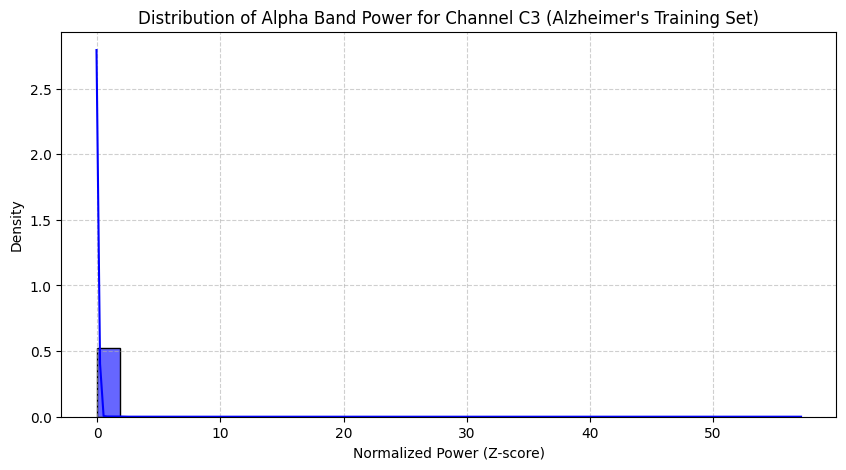

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract only the "Alpha" band for channel "C3"
alpha_c3_data = alz_train_scaled.loc[("C3", "Alpha"), "Window Avg"]

# Ensure data is in list format
if isinstance(alpha_c3_data, list) or isinstance(alpha_c3_data, np.ndarray):
    plt.figure(figsize=(10, 5))

    # Plot histogram with density estimation (Kernel Density Estimation - KDE)
    sns.histplot(alpha_c3_data, bins=30, kde=True, color="blue", stat="density", alpha=0.6)

    plt.ylabel("Density")
    plt.xlabel("Normalized Power (Z-score)")
    plt.title("Distribution of Alpha Band Power for Channel C3 (Alzheimer's Training Set)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
else:
    print("⚠️ The extracted data is not in list format. Check if 'Window Avg' contains lists of values.")


In [101]:

#**highly skeptical of this **
from sklearn.preprocessing import StandardScaler
import numpy as np

# Function to normalize train & test data per band using training parameters
def normalize_band(train_df, test_df):
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Convert "Window Avg" lists to NumPy arrays
    train_df["Window Avg"] = train_df["Window Avg"].apply(lambda x: np.array(x) if isinstance(x, list) else x)
    test_df["Window Avg"] = test_df["Window Avg"].apply(lambda x: np.array(x) if isinstance(x, list) else x)

    # Fit scaler separately for each row (instead of on the whole dataset)
    def scale_list(scaler, x):
        x = x.reshape(-1, 1)  # Ensure correct shape for StandardScaler
        return scaler.fit_transform(x).flatten()  # Fit & transform per row

    train_df["Window Avg"] = train_df["Window Avg"].apply(lambda x: scale_list(StandardScaler(), x))
    test_df["Window Avg"] = test_df["Window Avg"].apply(lambda x: scale_list(StandardScaler(), x))

    return train_df, test_df

# Apply function to each Band separately for Alzheimer's group
alz_train_scaled, alz_test_scaled = zip(*alz_train_df_combined.groupby("Band", group_keys=False).apply(
    lambda g: normalize_band(g, alz_test_df_combined.loc[g.index])
).values)

# Apply function to each Band separately for Control group
control_train_scaled, control_test_scaled = zip(*control_train_df_combined.groupby("Band", group_keys=False).apply(
    lambda g: normalize_band(g, control_test_df_combined.loc[g.index])
).values)


print(alz_train_scaled)
print(alz_test_scaled)
print(control_train_scaled)
print(control_test_scaled)

# Print first few rows
#print(alz_train_scaled.head())
#print(alz_test_scaled.head())
#print(control_train_scaled.head())
#print(control_test_scaled.head())


(                                                      Window Avg
Channel Band                                                    
C3      Alpha  [-0.04686726223962491, -0.04661130577141434, -...
C4      Alpha  [-0.04760613651720091, -0.04892202669828345, -...
Cz      Alpha  [-0.04817863495359442, -0.047677641739982846, ...
F3      Alpha  [-0.04896373618934346, -0.04827272701695156, -...
F4      Alpha  [-0.04836769435505512, -0.049180375552753515, ...
F7      Alpha  [-0.050449410580874134, -0.05032048879978084, ...
F8      Alpha  [-0.04382649018252775, -0.044773102316942016, ...
Fp1     Alpha  [-0.04297289274833778, -0.04886054118973562, -...
Fp2     Alpha  [-0.04346906694177611, -0.04848360613177401, -...
Fz      Alpha  [-0.04956024009811652, -0.04948518192795945, -...
O1      Alpha  [-0.03504835336925742, -0.035280954786490216, ...
O2      Alpha  [-0.0479543003007958, -0.04817912603633828, -0...
P3      Alpha  [-0.05223056380676035, -0.05213337976278488, -...
P4      Alpha  [-0.04339

In [83]:
# Merge all Window Avg values for each (Channel, Band) into a single list
alz_combined = alz_combined.groupby(["Channel", "Band"])["Window Avg"].sum()
control_combined = control_combined.groupby(["Channel", "Band"])["Window Avg"].sum()

# Convert back to DataFrame (optional)
alz_combined = alz_combined.to_frame()
control_combined = control_combined.to_frame()

# Print results
print(alz_combined.head())
print(control_combined.head())

                                                      Window Avg
Channel Band                                                    
C3      Alpha  [1.1952646428442352e-09, 1.243587730757724e-09...
        Beta   [3.440334682399176e-10, 3.3680858853976883e-10...
        Delta  [1.343193533659429e-07, 2.6631502953716043e-07...
        Theta  [4.612288195341671e-09, 5.628089980277074e-09,...
C4      Alpha  [1.15823465152569e-09, 9.120024993533683e-10, ...
                                                      Window Avg
Channel Band                                                    
C3      Alpha  [2.1527058139996137e-09, 1.899380401941476e-09...
        Beta   [3.2686312023167596e-10, 2.953228713639168e-10...
        Delta  [1.289780396177284e-07, 1.1712672841658123e-07...
        Theta  [3.621755806117966e-09, 4.970567975602138e-09,...
C4      Alpha  [2.054821034173802e-09, 2.2006669884943113e-09...


In [94]:
#checking the state
print(alz_combined) 
print(control_combined) 

print(type(control_combined.loc[('Fp1', 'Delta'), "Window Avg"]))
print(type(control_combined.loc[('Fp1', 'Delta'), "Window Avg"][0]))
# print((control_combined.loc[('Fp1', 'Delta'), "Window Avg"]))
# print(alz_combined.loc[('sub-001', 'Fp1', 'Delta'), "Window Avg"][0])

                                                      Window Avg
Channel Band                                                    
C3      Alpha  [1.1952646428442352e-09, 1.243587730757724e-09...
        Beta   [3.440334682399176e-10, 3.3680858853976883e-10...
        Delta  [1.343193533659429e-07, 2.6631502953716043e-07...
        Theta  [4.612288195341671e-09, 5.628089980277074e-09,...
C4      Alpha  [1.15823465152569e-09, 9.120024993533683e-10, ...
...                                                          ...
T5      Theta  [4.5882640670242895e-09, 6.594935864443824e-09...
T6      Alpha  [1.3621702809217911e-09, 1.6064003784801627e-0...
        Beta   [3.841039340557157e-10, 4.743714072500563e-10,...
        Delta  [1.7175379583888522e-07, 2.6736669150319846e-0...
        Theta  [3.6770714985585547e-09, 5.717439153997815e-09...

[76 rows x 1 columns]
                                                      Window Avg
Channel Band                                                    
C3

In [95]:
#This ensures everything is a single item list or array, shouldn't be needed but its a safety net
alz_combined["Window Avg"] = alz_combined["Window Avg"].apply(lambda x: float(x) if isinstance(x, (list, np.ndarray)) and len(x) == 1 else x)
control_combined["Window Avg"] = control_combined["Window Avg"].apply(lambda x: float(x) if isinstance(x, (list, np.ndarray)) and len(x) == 1 else x)

print(alz_combined)
print(control_combined) #check that all the channels are here , looks like they got moved

                                                      Window Avg
Channel Band                                                    
C3      Alpha  [1.1952646428442352e-09, 1.243587730757724e-09...
        Beta   [3.440334682399176e-10, 3.3680858853976883e-10...
        Delta  [1.343193533659429e-07, 2.6631502953716043e-07...
        Theta  [4.612288195341671e-09, 5.628089980277074e-09,...
C4      Alpha  [1.15823465152569e-09, 9.120024993533683e-10, ...
...                                                          ...
T5      Theta  [4.5882640670242895e-09, 6.594935864443824e-09...
T6      Alpha  [1.3621702809217911e-09, 1.6064003784801627e-0...
        Beta   [3.841039340557157e-10, 4.743714072500563e-10,...
        Delta  [1.7175379583888522e-07, 2.6736669150319846e-0...
        Theta  [3.6770714985585547e-09, 5.717439153997815e-09...

[76 rows x 1 columns]
                                                      Window Avg
Channel Band                                                    
C3

# Now we are normalizing and applying PCA

In [103]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Function to apply StandardScaler per band
def normalize_band(df):
    df = df.copy()  # Avoid modifying original dataframe
    scaler = StandardScaler()
    
    # Convert "Window Avg" lists to NumPy arrays
    df["Window Avg"] = df["Window Avg"].apply(lambda x: np.array(x) if isinstance(x, list) else x)
    
    # Stack arrays into a 2D matrix
    X = np.vstack(df["Window Avg"].values)  
    
    # Scale values
    X_scaled = scaler.fit_transform(X)
    
    # Store back in DataFrame
    df["Window Avg"] = list(X_scaled)
    
    return df

# Apply function to each Band separately
alz_scaled = alz_combined.groupby("Band", group_keys=False).apply(normalize_band)
control_scaled = control_combined.groupby("Band", group_keys=False).apply(normalize_band)

# Print first few rows
print(alz_scaled.head())
print(control_scaled.head())


[[1.19526464e-09 1.24358773e-09 1.14422465e-09 ... 1.04039027e-09
  1.14957071e-09 8.72237207e-10]
 [1.15823465e-09 9.12002499e-10 1.02765620e-09 ... 1.08116609e-09
  1.14999732e-09 7.75782900e-10]
 [1.12811121e-09 1.22159138e-09 1.11538457e-09 ... 8.90449012e-10
  9.52819757e-10 7.96263853e-10]
 ...
 [1.21050687e-09 1.26062901e-09 1.13313572e-09 ... 2.84172598e-09
  2.82322287e-09 1.35255805e-09]
 [1.73123748e-09 1.78767216e-09 1.38269672e-09 ... 1.88259031e-09
  2.59158197e-09 1.76563586e-09]
 [1.36217028e-09 1.60640038e-09 1.56427322e-09 ... 2.17809250e-09
  1.49192671e-09 1.02444950e-09]]
[[3.44033468e-10 3.36808589e-10 3.28769207e-10 ... 2.58424310e-10
  3.84902130e-10 3.59259125e-10]
 [3.08823832e-10 3.68182253e-10 3.05810501e-10 ... 3.58707838e-10
  4.38736412e-10 3.98179065e-10]
 [3.20589999e-10 3.53352485e-10 3.02441922e-10 ... 3.13185314e-10
  3.86040425e-10 4.08682536e-10]
 ...
 [5.21389792e-10 4.87712033e-10 3.67222124e-10 ... 6.76504075e-10
  7.55545687e-10 7.50272765e-10]